
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Make at least 1 Shapley force plot to explain an individual prediction.
- [X] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [11]:
# Imports
import pandas as pd
import numpy as np

# Create dataframe of project data
potholes = pd.read_csv('../../Unit 2 Build Week/Pothole Requests after 10.15.18.csv')

In [2]:
# Change output viewing options
pd.set_option('display.max_columns', 50)

# Look at data
potholes.head()

,CASE ID,SOURCE,DEPARTMENT,WORK GROUP,REQUEST TYPE,CATEGORY,TYPE,DETAIL,CREATION DATE,CREATION TIME,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,CLOSED DATE,CLOSED MONTH,CLOSED YEAR,DAYS TO CLOSE,STREET ADDRESS,ADDRESS WITH GEOCODE,ZIP CODE,NEIGHBORHOOD,COUNTY,COUNCIL DISTRICT,POLICE DISTRICT,PARCEL ID NO,LATITUDE,LONGITUDE,CASE URL,30-60-90 Days Open Window
0,2019169222,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,09/20/2019,01:31 PM,9,2019,RESOL,Y,11/07/2019,11.0,2019.0,48.0,13110 E 57th St,"13110 E 57th St64133\n(39.018605, -94.426046)",64133,Blue Vue Hills,Jackson,5,East,63787,39.018605,-94.426046,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
1,2019126105,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,07/03/2019,08:30 AM,7,2019,RESOL,Y,10/24/2019,10.0,2019.0,113.0,1420 E 75th Ter,"1420 E 75th Ter64131\n(38.990601, -94.570141)",64131,East Meyer 6,Jackson,5,Metro,115894,38.990601,-94.570141,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
2,2019126468,WEB,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,07/03/2019,01:53 PM,7,2019,RESOL,Y,10/24/2019,10.0,2019.0,113.0,5500 Michigan Ave,"5500 Michigan Ave64130\n(39.026622, -94.563667)",64130,Blue Hills,Jackson,5,Metro,147750,39.026622,-94.563667,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
3,2019183619,PHONE,Public Works,Public Works-Street and Traffic-District 1,Streets / Roadways / Alleys-Pothole-District 1,Streets / Roadways / Alleys,Pothole,District 1,10/23/2019,09:36 AM,10,2019,RESOL,Y,11/22/2019,11.0,2019.0,30.0,6344 NE Pleasant Valley Rd,"6344 NE Pleasant Valley Rd64119\n(39.216929, -...",64119,Shoal Creek,Clay,1,Shoal Creek,89139,39.216929,-94.504961,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
4,2019190590,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,11/08/2019,10:27 AM,11,2019,RESOL,Y,11/18/2019,11.0,2019.0,10.0,9500 Blue Ridge Blvd,"9500 Blue Ridge Blvd64134\n(38.952042, -94.508...",64134,Fairlane,Jackson,5,South,56861,38.952042,-94.508463,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN


In [33]:
# Convert CREATION DATE to datetime to prepare for data split
potholes['CREATION DATE'] = pd.to_datetime(potholes['CREATION DATE'])

# Split data into train, validate, and test sets

# Set train to Oct 15, 2018 (first freeze of 2018) - June 14, 2019
train = potholes[potholes['CREATION DATE'] < '2019-06-15']

# Set val to the next two months of the dataset
val = potholes[(potholes['CREATION DATE'] >= '2019-06-15') 
               & (potholes['CREATION DATE'] < '2019-08-15')]

# Set test to the last two months of the year following start date
test = potholes[(potholes['CREATION DATE'] >= '2019-08-15')
               & (potholes['CREATION DATE'] < '2019-10-15')]

train.shape, val.shape, test.shape

((14864, 30), (2625, 30), (1268, 30))

In [20]:
# Find mean baseline for train
target = 'DAYS TO CLOSE'
baseline = train[target].mean()
print(f'Baseline Mean: {baseline:.2f} days')

# Find baseline MAE
from sklearn.metrics import mean_absolute_error
y_train = train[target].dropna()
y_pred = [baseline] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Baseline Mean Absolute Error: {mae:.2f} days')
print('Baseline R^2: 0')

Baseline Mean: 40.96 days
Baseline Mean Absolute Error: 32.56 days
Baseline R^2: 0


In [7]:
train.head(1)

,CASE ID,SOURCE,DEPARTMENT,WORK GROUP,REQUEST TYPE,CATEGORY,TYPE,DETAIL,CREATION DATE,CREATION TIME,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,CLOSED DATE,CLOSED MONTH,CLOSED YEAR,DAYS TO CLOSE,STREET ADDRESS,ADDRESS WITH GEOCODE,ZIP CODE,NEIGHBORHOOD,COUNTY,COUNCIL DISTRICT,POLICE DISTRICT,PARCEL ID NO,LATITUDE,LONGITUDE,CASE URL,30-60-90 Days Open Window
95,2019098986,WEB,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-05-22,11:48 AM,5,2019,RESOL,Y,10/24/2019,10.0,2019.0,155.0,6301 Vernon Ct,"6301 Vernon Ct64133\n(39.007281, -94.431637)",64133,Little Blue,Jackson,5,East,64466,39.007281,-94.431637,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN


In [49]:
# Convert CLOSED DATE to datetime
train = train.copy()
train['CLOSED DATE'] = pd.to_datetime(train['CLOSED DATE'])
sample = train.head(5)
sample

,CASE ID,SOURCE,DEPARTMENT,WORK GROUP,REQUEST TYPE,CATEGORY,TYPE,DETAIL,CREATION DATE,CREATION TIME,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,CLOSED DATE,CLOSED MONTH,CLOSED YEAR,DAYS TO CLOSE,STREET ADDRESS,ADDRESS WITH GEOCODE,ZIP CODE,NEIGHBORHOOD,COUNTY,COUNCIL DISTRICT,POLICE DISTRICT,PARCEL ID NO,LATITUDE,LONGITUDE,CASE URL,30-60-90 Days Open Window
95,2019098986,WEB,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-05-22,11:48 AM,5,2019,RESOL,Y,2019-10-24,10.0,2019.0,155.0,6301 Vernon Ct,"6301 Vernon Ct64133\n(39.007281, -94.431637)",64133,Little Blue,Jackson,5,East,64466,39.007281,-94.431637,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
221,2019075215,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-04-17,03:04 PM,4,2019,RESOL,Y,2019-10-24,10.0,2019.0,190.0,6904 Kensington Ave,"6904 Kensington Ave64132\n(39.000465, -94.536087)",64132,Foxtown East,Jackson,5,Metro,4490,39.000465,-94.536087,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
222,2019099795,EMAIL,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-05-23,11:02 AM,5,2019,RESOL,Y,2019-10-24,10.0,2019.0,154.0,5401 Michigan Ave,"5401 Michigan Ave64130\n(39.028515, -94.562877)",64130,Blue Hills,Jackson,5,Metro,145773,39.028515,-94.562877,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
361,2019066849,WEB,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-04-04,11:58 AM,4,2019,RESOL,Y,2019-10-25,10.0,2019.0,204.0,1267 W 61st St,"1267 W 61st St64113\n(39.017382, -94.607369)",64113,Stratford Gardens,Jackson,6,Metro,108743,39.017382,-94.607369,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN
374,2019080980,EMAIL,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,Streets / Roadways / Alleys,Pothole,District 3,2019-04-25,01:10 PM,4,2019,RESOL,Y,2019-10-18,10.0,2019.0,176.0,7440 Harrison St,"7440 Harrison St64131\n(38.9918, -94.577173)",64131,Tower Homes,Jackson,6,Metro,113644,38.991800,-94.577173,http://city.kcmo.org/kc/ActionCenterRequest/Ca...,NaN


In [69]:
sample['CLOSED DATE'] - sample ['CREATION DATE']
(sample['CREATION DATE'] <= (sample.iloc[0,8])).sum()

a= []
for date in sample['CREATION DATE']:
    a.append(((sample['CREATION DATE'] <= date) & (sample['CLOSED DATE'] > date)).sum())
a    

[4, 2, 5, 1, 3]

In [66]:
((train['CREATION DATE'] <= (sample.iloc[0,8])) & (train['CLOSED DATE'] > (sample.iloc[0,8]))).sum()

4666

In [73]:
def wrangle(X):
    
    '''Wrangles train, validate, and test sets in the same way'''
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    # Use only 'Resolved' cases
    X = X[X['STATUS'] == 'RESOL']
    
    # Ensure no remaining null values in target column
    X = X.dropna(subset=['DAYS TO CLOSE'])
    
    # Use only rows with greater than 0 days to close
    X = X[X['DAYS TO CLOSE'] > 0]
    
    # Convert CLOSED DATE to datetime
    
    X['CLOSED DATE'] = pd.to_datetime(X['CLOSED DATE'])
    
    # Add column for number of current cases open when a given report comes in
    a= []
    for date in X['CREATION DATE']:
        a.append(((X['CREATION DATE'] <= date) & (X['CLOSED DATE'] > date)).sum())
    X['OPEN CASES'] = a    
    
    # Drop columns with constant values
    constant = ['DEPARTMENT', 'CATEGORY', 'TYPE']
    X = X.drop(columns=constant)
    
    # Drop columns with duplicate values
    duplicate = ['REQUEST TYPE', 'ADDRESS WITH GEOCODE']
    X = X.drop(columns=duplicate)
    
    # Drop column at risk for leakage
    leakage = ['EXCEEDED EST TIMEFRAME', '30-60-90 Days Open Window',
              'CLOSED MONTH', 'CLOSED YEAR', 'CLOSED DATE']
    X = X.drop(columns=leakage)
    
    # Drop high cardinality columns
    cardinality = ['CASE ID', 'STREET ADDRESS', 'NEIGHBORHOOD', 
                   'PARCEL ID NO', 'CASE URL', 'CREATION DATE',
                  'CREATION TIME']
    X = X.drop(columns=cardinality)
    
    # Convert ZIP CODE to categorical variable
    X['ZIP CODE'] = X['ZIP CODE'].astype('str')
    
    # Remove latitude/longitude points outside Kansas City
    X = X[(X['LATITUDE'] > 38.8) & (X['LATITUDE'] < 39.4)]
    X = X[(X['LONGITUDE'] > -94.8) & (X['LONGITUDE'] < -94.3)]
      
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [75]:
print(train_wrangled.shape)
train_wrangled.head(5)

(14532, 14)


,SOURCE,WORK GROUP,DETAIL,CREATION MONTH,CREATION YEAR,STATUS,DAYS TO CLOSE,ZIP CODE,COUNTY,COUNCIL DISTRICT,POLICE DISTRICT,LATITUDE,LONGITUDE,OPEN CASES
95,WEB,Public Works-Street and Traffic-District 3,District 3,5,2019,RESOL,155.0,64133,Jackson,5,East,39.007281,-94.431637,4665
221,PHONE,Public Works-Street and Traffic-District 3,District 3,4,2019,RESOL,190.0,64132,Jackson,5,Metro,39.000465,-94.536087,3573
222,EMAIL,Public Works-Street and Traffic-District 3,District 3,5,2019,RESOL,154.0,64130,Jackson,5,Metro,39.028515,-94.562877,4758
361,WEB,Public Works-Street and Traffic-District 3,District 3,4,2019,RESOL,204.0,64113,Jackson,6,Metro,39.017382,-94.607369,3111
374,EMAIL,Public Works-Street and Traffic-District 3,District 3,4,2019,RESOL,176.0,64131,Jackson,6,Metro,38.991800,-94.577173,4030


In [76]:
# Arrange data into X features matrix and y target vector
target = 'DAYS TO CLOSE'
X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]
X_val = val_wrangled.drop(columns=target)
y_val = val_wrangled[target]
X_test = test_wrangled.drop(columns=target)
y_test = test_wrangled[target]

In [79]:
# Imports for pipeline
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor

# Create pipeline for Random Forest Regressor
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100, random_state=7, min_samples_leaf=40, n_jobs=-1)   
)

# Fit on train df
pipeline.fit(X_train, y_train)

print('Train R^2', pipeline.score(X_train, y_train))
y_pred = pipeline.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: {mae:.2f} days\n')

print('Validation R^2', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation Mean Absolute Error: {mae:.2f} days')

Train R^2 0.42569749764919457
Train Mean Absolute Error: 21.52 days

Validation R^2 -0.8663362069668671
Validation Mean Absolute Error: 26.82 days


In [95]:
# Import XGBoost
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=7, n_jobs=-1, reg='squarederror')
)

# Fit on train df
pipeline.fit(X_train, y_train)

# Print evaluation metrics for train data
y_pred = pipeline.predict(X_train)
print('Train R^2', r2_score(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: {mae:.2f} days\n')

# Print evaluation metrics for validation data
y_pred = pipeline.predict(X_val)
print('Validation R^2', pipeline.score(X_val, y_val))
print('Validation R^2', r2_score(y_val, y_pred))
print(f'Validation Mean Absolute Error: {mae:.2f} days')

/Users/loris/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/loris/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:03:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train R^2 0.33789423148666453
Train Mean Absolute Error: 23.89 days

Validation R^2 -0.3727557119401417
Validation R^2 -0.3727557119401417
Validation Mean Absolute Error: 23.89 days


In [120]:
# Encode categorical data
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Set up XGB model
model = XGBRegressor(
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.2,
    n_jobs=-1,
    reg='squarederror'
)

# Define eval_set
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]

# Fit model, with early stopping rounds
model.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='mae',
         early_stopping_rounds=50)


[17:25:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:33.9043	validation_1-mae:28.2282
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:28.6773	validation_1-mae:25.0204
[2]	validation_0-mae:24.8725	validation_1-mae:24.1338
[3]	validation_0-mae:22.1861	validation_1-mae:24.2886
[4]	validation_0-mae:20.1411	validation_1-mae:24.6869
[5]	validation_0-mae:18.5227	validation_1-mae:25.2759
[6]	validation_0-mae:17.2844	validation_1-mae:25.868
[7]	validation_0-mae:16.2971	validation_1-mae:26.3035
[8]	validation_0-mae:15.4933	validation_1-mae:26.7662
[9]	validation_0-mae:14.8925	validation_1-mae:27.2893
[10]	validation_0-mae:14.4862	validation_1-mae:27.5941
[11]	validation_0-mae:13.9925	validation_1-mae:27.6866
[12]	validation_0-mae:13.7182	validation_1-mae:27.909
[13]	validation_0-mae:13

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg='squarederror', reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

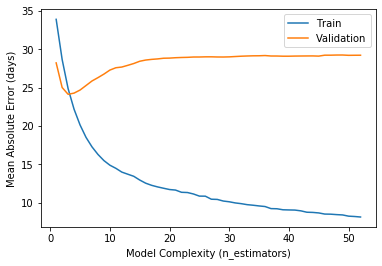

In [121]:
# Chart results of XGBoost Parameter tuning
model.evals_result()

import matplotlib.pyplot as plt
results = model.evals_result()
train_error = results['validation_0']['mae']
val_error = results['validation_1']['mae']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Mean Absolute Error (days)')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend()
plt.show()

In [122]:
# Print validation metrics for best iteration of XGBoost
print('Validation Metrics for Best Validation Iteration of XGBRegressor')
y_pred = model.predict(X_train_encoded)
print('Train R^2', r2_score(y_train, y_pred))
print('Train R^2', model.score(X_train_encoded, y_train))
mae = results['validation_0']['mae'][model.best_iteration]
print(f'Train Mean Absolute Error: {mae:.2f} days\n')

print('Validation R^2', model.score(X_val_encoded, y_val))
#y_pred = model.predict(X_val_encoded)
mae = results['validation_1']['mae'][model.best_iteration]
print(f'Validation Mean Absolute Error: {mae:.2f} days')

Validation Metrics for Best Validation Iteration of XGBRegressor
Train R^2 0.10894382828419635
Train R^2 0.10894382828419635
Train Mean Absolute Error: 24.87 days

Validation R^2 -0.6869609276536773
Validation Mean Absolute Error: 24.13 days


In [123]:
# Get permutation importances
import eli5
from eli5.sklearn import PermutationImportance

# Calculate permutation importances
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=7
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.2,
                                             max_delta_step=0, max_depth=12,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg='squarederror',
                                             reg_alpha=0, reg_lambda=1,
                                    

In [124]:
# Get permutation importances
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(
    permuter,
    top=30,
    feature_names=feature_names
)

Weight,Feature
0.9165 ± 0.2332,COUNTY
0.7550 ± 0.1379,WORK GROUP
0.4052 ± 0.2958,LATITUDE
0.0910 ± 0.0724,COUNCIL DISTRICT
0 ± 0.0000,STATUS
0 ± 0.0000,CREATION YEAR
0 ± 0.0000,CREATION MONTH
-0.0001 ± 0.0004,DETAIL
-0.0212 ± 0.0136,POLICE DISTRICT
-0.1744 ± 0.2426,SOURCE


### Partial Dependence Plot

In [101]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
!pip install pdpbox

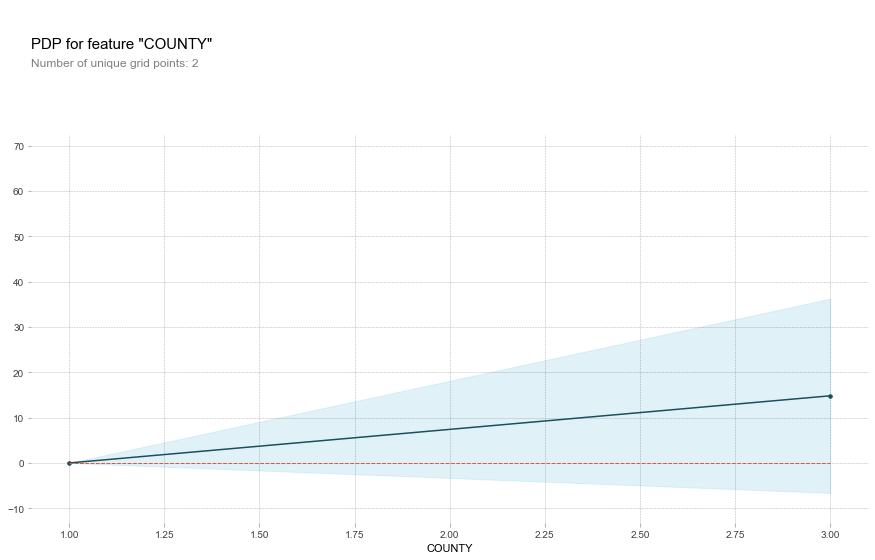

In [137]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
feature = 'COUNTY'

pdp_dist = pdp.pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=feature
)

pdp.pdp_plot(pdp_dist, feature_name=feature);

In [134]:
encoder.mapping

[{'col': 'SOURCE', 'mapping': WEB      1
  PHONE    2
  EMAIL    3
  TWIR     4
  EIP      5
  EDC      6
  MAIL     7
  SYS      8
  NaN     -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'WORK GROUP',
  'mapping': Public Works-Street and Traffic-District 3    1
  Public Works-Street and Traffic-District 2    2
  Public Works-Street and Traffic-District 1    3
  NaN                                          -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'DETAIL', 'mapping': District 3    1
  District 2    2
  District 1    3
  Bridge        4
  NaN          -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'STATUS', 'mapping': RESOL    1
  NaN     -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'ZIP CODE', 'mapping': 64133     1
  64132     2
  64130     3
  64113     4
  64131     5
  64138     6
  64146     7
  64145     8
  64149     9
  64136    10
  64114    11
  64153    12
  64156    13
  64112    14
  64127    15
  64119    16
  64134    17
  64155    

([<matplotlib.axis.XTick at 0x1a266fb450>,
 <a list of 4 Text xticklabel objects>)

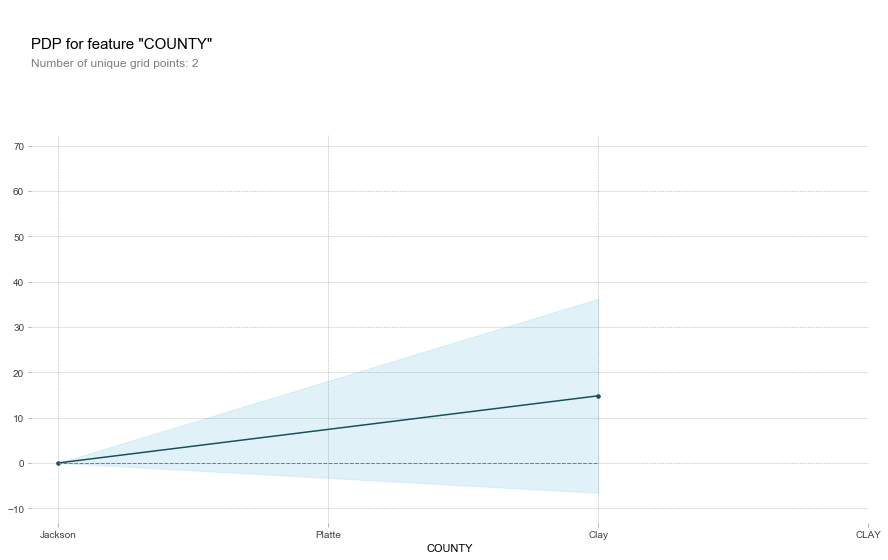

In [139]:
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([1, 2, 3, 4], ['Jackson', 'Platte', 'Clay', 'CLAY'])

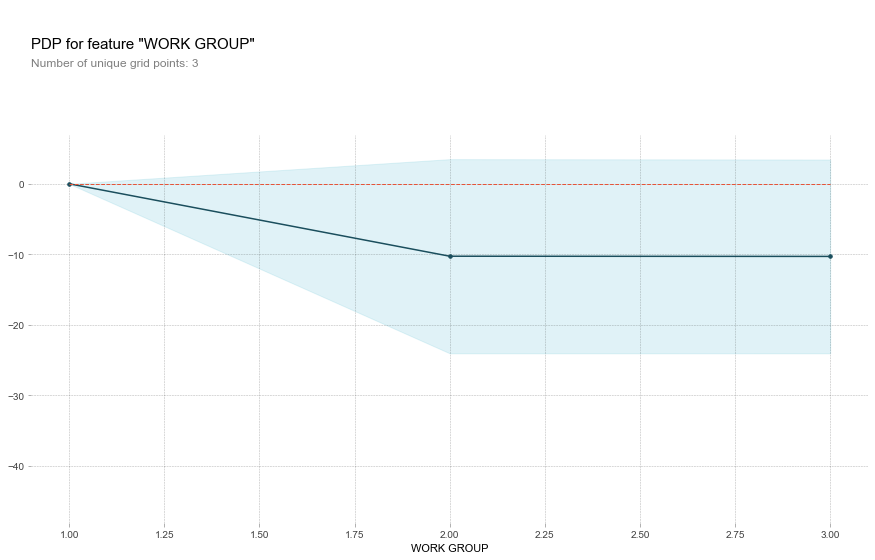

In [117]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'WORK GROUP'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a252f2ed0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2532a790>})

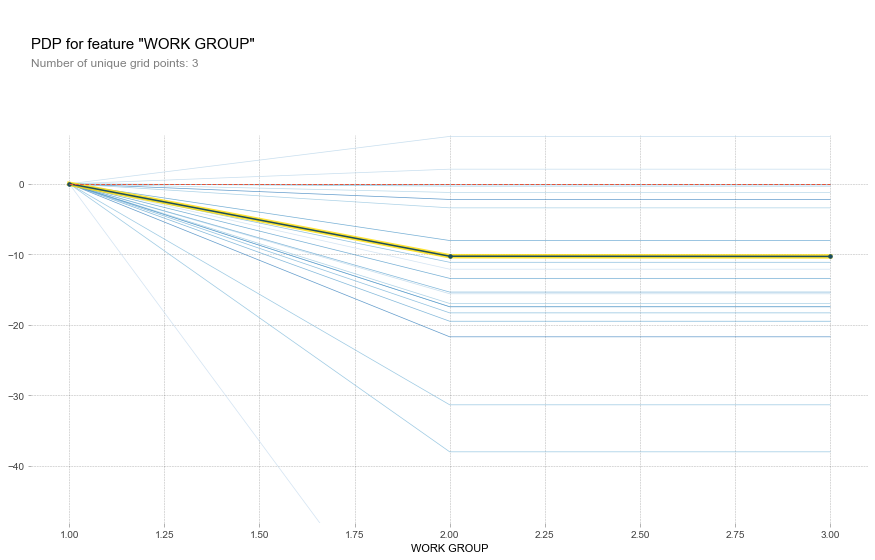

In [119]:
# Plot PDP with 100 ICE curves
pdp_plot(isolated, feature_name=feature, plot_lines=True,
         frac_to_plot=0.01)


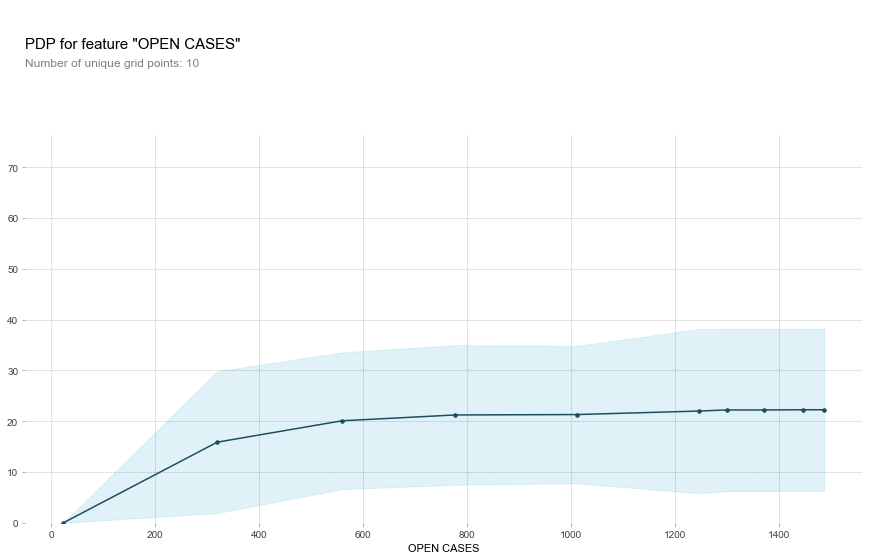

In [125]:
feature = 'OPEN CASES'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a259f9ed0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a26116c10>})

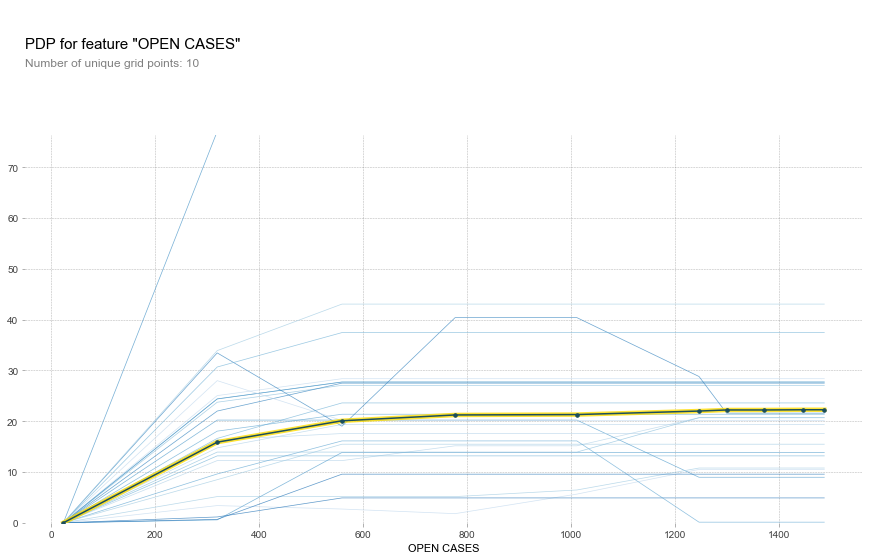

In [126]:
# Plot PDP with 100 ICE curves
pdp_plot(isolated, feature_name=feature, plot_lines=True,
         frac_to_plot=0.01)

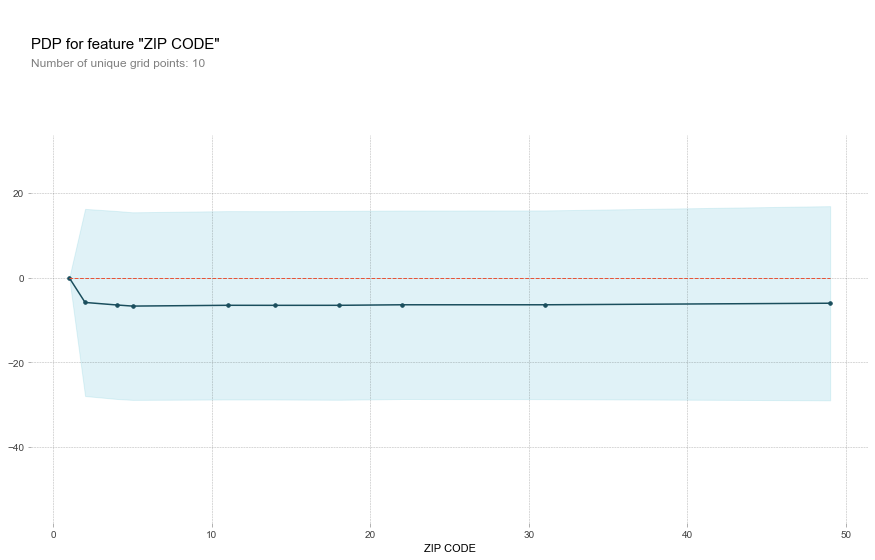

In [129]:
feature = 'ZIP CODE'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [130]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [131]:
features = ['OPEN CASES', 'COUNTY']

interaction = pdp_interact(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

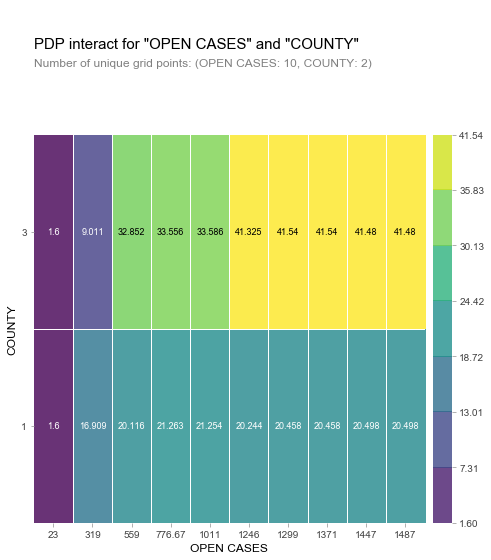

In [140]:
pdp_interact_plot(interaction, plot_type='grid',
                 feature_names=features);

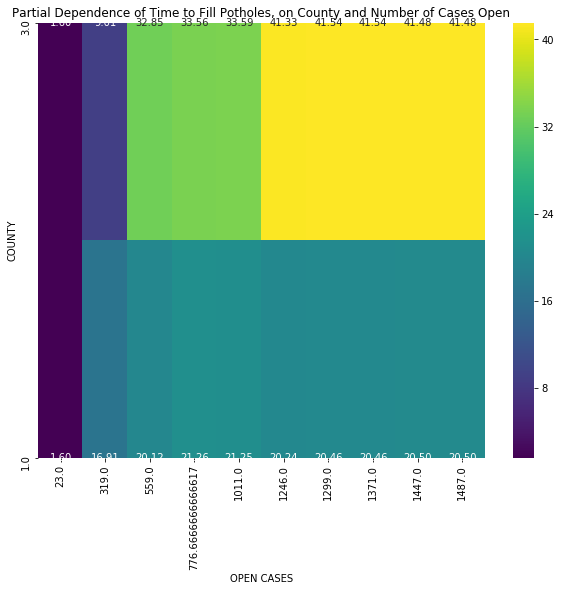

In [147]:
import seaborn as sns

feature = 'COUNTY'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Time to Fill Potholes, on County and Number of Cases Open');

In [150]:
row = X_train_encoded.iloc[[0]]
y_train.iloc[[0]]

95    155.0
Name: DAYS TO CLOSE, dtype: float64

In [151]:
model.predict(row)

array([37.451363], dtype=float32)

In [ ]:
!pip install shap

In [154]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

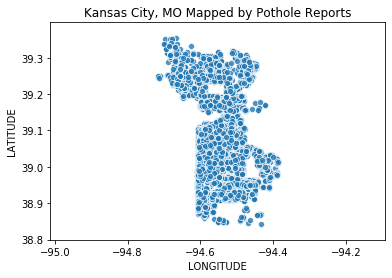

In [155]:
import seaborn as sns
plt.axis('equal')
plt.title('Kansas City, MO Mapped by Pothole Reports')
#fig
sns.scatterplot(x=X_train['LONGITUDE'], 
                y=X_train['LATITUDE'], 
                alpha=.8);